In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
from dichotomous_multiplication_model_functions import *

In [3]:
index_cols=['location_id','sex_id','age_group_id']

age_group_ids = [2,3,4,5]
sex_ids = [1,2]
coverage_levels = [0.2,0.5,0.8,1]
years = [2021,2022,2023,2024,2025]

nutrient = 'iron'
vehicle = 'wheat flour'

location_ids = [163, 214]

In [4]:
effective_fractions = [0, 
                       0, 
                       0.1666666667, 
                       0.9166666667]

In [5]:
baseline_coverage, counterfactual_coverage = generate_overall_coverage_rates(nutrient, 
                                                                             vehicle,
                                                                             coverage_levels,
                                                                             years,
                                                                             location_ids)

In [41]:
data = pd.read_csv(
    '/ihme/homes/alibow/notebooks/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/LSFF_extraction_clean_data_rich_locations_01_11_2021.csv')
data = data.loc[data.location_id.isin(location_ids)].loc[data.vehicle=='wheat flour'].loc[data.nutrient.isin(['na','iron'])]
data

,location_id,location_name,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
5,163,India,wheat flour,percent of population eating fortified vehicle,iron,6.300000,4.800000,7.900000
10,163,India,wheat flour,percent of population eating industrially prod...,na,7.100000,5.600000,9.100000
11,163,India,wheat flour,percent of population eating vehicle,na,83.200000,79.500000,86.500000
25,214,Nigeria,wheat flour,percent of population eating fortified vehicle,iron,16.799661,14.474827,19.156283
30,214,Nigeria,wheat flour,percent of population eating industrially prod...,na,59.925796,57.559902,62.291690
31,214,Nigeria,wheat flour,percent of population eating vehicle,na,60.128114,57.728114,62.494008


In [42]:
6.3/7.1

0.8873239436619719

In [43]:
16.8/57.6

0.2916666666666667

In [29]:
baseline_coverage.mean(axis=1)

location_id  year
163          2021    0.063182
             2022    0.063182
             2023    0.063182
             2024    0.063182
             2025    0.063182
214          2021    0.168421
             2022    0.168421
             2023    0.168421
             2024    0.168421
             2025    0.168421
dtype: float64

In [6]:
from scipy.stats import norm

# mean and 0.975-quantile of normal distribution for mean difference (MD)
mean = 3
q_975 = 6.1

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

std = (q_975 - mean) / q_975_stdnorm # std dev of normal distribution

# Frozen normal distribution for MD, representing uncertainty in our effect size
hb_md_distribution = norm(mean, std)

In [7]:
def generate_rr_deficiency_nofort_draws(mean, std, location_ids):
    import pandas as pd, numpy as np
    """This function takes a distribution for the relative risk
    for lack of fortification of a particular nutrient and generates
    1,000 draws based on that distribution. The data is the duplicated
    so that it is the same for each location ID so that it can be easily
    used later in the calculations."""
    data = pd.DataFrame()
    np.random.seed(7)
    data['rr'] = np.random.normal(mean, std, size=1000)
    draws = []
    for i in list(range(0, 1000)):
        draws.append(f'draw_{i}')
    data['draws'] = draws
    data = pd.DataFrame.pivot_table(data, values='rr', columns='draws').reset_index().drop(columns=['index'])
    df = pd.DataFrame(np.repeat(data.values, len(location_ids), axis=0))
    df.columns = data.columns
    df['location_id'] = location_ids
    df = df.set_index('location_id')
    return df

In [8]:
mean_difference_hemoglobin_fort = generate_rr_deficiency_nofort_draws(mean, std, location_ids)
mean_difference_hemoglobin_fort.head()

draws,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
163,5.67384,2.263045,2.010783,1.632669,3.592127,3.619293,0.71747,3.769218,2.099288,5.25659,...,2.68253,2.315703,4.976409,5.670455,1.949907,3.061148,3.881265,2.227427,2.005891,1.92852
214,5.67384,2.263045,2.010783,1.632669,3.592127,3.619293,0.71747,3.769218,2.099288,5.25659,...,2.68253,2.315703,4.976409,5.670455,1.949907,3.061148,3.881265,2.227427,2.005891,1.92852


In [9]:
def apply_iron_hemoglobin_age_related_effective_coverage_restrictions(data,
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions):
    """This function takes an dataframe of population coverage and generates a dataframe of *effective* coverage
    rates by age group, using the effective coverage assumptions for vitamin A by age (no effect of fortification under
    six months of age)"""
    final = pd.DataFrame()
    for n in list(range(0, len(sex_ids))):
        out_data = pd.DataFrame()
        for i in list(range(0, len(age_group_ids))):
            temp = (data * effective_fractions[i]).reset_index()
            temp['age_group_id'] = age_group_ids[i]
            out_data = pd.concat([out_data, temp], ignore_index=True)
        out_data['sex_id'] = sex_ids[n]
        final = pd.concat([final, out_data], ignore_index=True)
    final = (final.set_index(
        ['location_id', 'age_group_id', 'sex_id', 'year'] + [c for c in final.columns if c == 'coverage_level'])
             .sort_index())
    return final


def calculate_iron_hemoglobin_time_lag_effective_fraction(df, years):
    """This function calculates the proportion of individuals covered by vitamin a fortification who
    are recieving an effect from the fortification based on the time lag assumptions (5 month delay
    from the start of new coverage until vitamin a fortification has an effect on vitamin a deficiency).
    This function also assumes that everyone who is covered at baseline has been covered for at least five
    months and therefore 100% of covered individuals are effectively covered at baseline."""
    final = pd.DataFrame()
    data = df.reset_index()
    for i in list(range(0, len(years))):
        current = (data.loc[data.year == years[i]]
                   .set_index([c for c in data.columns if 'draw' not in c and c != 'year'])
                   .drop(columns='year'))
        if i == 0:
            for draw in list(range(0, 1000)):
                current[f'draw_{draw}'] = 1
        else:
            prior = (data.loc[data.year == years[i - 1]]
                     .set_index([c for c in data.columns if 'draw' not in c and c != 'year'])
                     .drop(columns='year'))
            current = 1 - ((current - prior) * 0.75 / current)
        current['year'] = years[i]
        final = pd.concat([final, current])
    final = final.reset_index().set_index([c for c in data.columns if 'draw' not in c]).sort_index()
    return final


def get_effective_iron_hemoglobin_coverage(df, sex_ids, age_group_ids, effective_fractions, years):
    """This function takes a total population coverage dataframe and applies age and time lag
    effective coverage restrictions for population levels of effective vitamin a fortification
    coverage by sex, age group, and year"""
    effective_coverage_by_age = apply_iron_hemoglobin_age_related_effective_coverage_restrictions(df,
                                                                                            sex_ids,
                                                                                            age_group_ids,
                                                                                            effective_fractions)
    effective_fraction_by_time_lag = calculate_iron_hemoglobin_time_lag_effective_fraction(df, years)
    effective_coverage = effective_coverage_by_age * effective_fraction_by_time_lag
    effective_coverage = (effective_coverage.reset_index()
                          .set_index(['location_id', 'sex_id', 'age_group_id', 'year'] +
                                     [c for c in effective_coverage.reset_index().columns if c == 'coverage_level'])
                          .sort_index())

    return effective_coverage

In [10]:
effective_baseline_coverage = get_effective_iron_hemoglobin_coverage(baseline_coverage, 
                                                                     sex_ids, 
                                                                     age_group_ids, 
                                                                     effective_fractions, 
                                                                     years)
effective_baseline_coverage

draw_0    draw_1    draw_2    draw_3  \
location_id sex_id age_group_id year                                          
163         1      2            2021  0.00000  0.000000  0.000000  0.000000   
                                2022  0.00000  0.000000  0.000000  0.000000   
                                2023  0.00000  0.000000  0.000000  0.000000   
                                2024  0.00000  0.000000  0.000000  0.000000   
                                2025  0.00000  0.000000  0.000000  0.000000   
...                                       ...       ...       ...       ...   
214         2      5            2021  0.13124  0.160583  0.153594  0.153648   
                                2022  0.13124  0.160583  0.153594  0.153648   
                                2023  0.13124  0.160583  0.153594  0.153648   
                                2024  0.13124  0.160583  0.153594  0.153648   
                                2025  0.13124  0.160583  0.153594  0.153648   

                                        draw_4    draw_5    draw_6    draw_7  \
location_id sex_id age_group_id year                                           
163         1      2            2021  0.000000  0.000000  0.000000  0.000000   
                                2022  0.000000  0.000000  0.000000  0.000000   
                                2023  0.000000  0.000000  0.000000  0.000000   
                                2024  0.000000  0.000000  0.000000  0.000000   
                                2025  0.000000  0.000000  0.000000  0.000000   
...                                        ...       ...       ...       ...   
214         2      5            2021  0.165458  0.140404  0.165764  0.157723   
                                2022  0.165458  0.140404  0.165764  0.157723   
                                2023  0.165458  0.140404  0.165764  0.157723   
                                2024  0.165458  0.140404  0.165764  0.157723   
                                2025  0.165458  0.140404  0.165764  0.157723   

                                        draw_8    draw_9  ...  draw_990  \
location_id sex_id age_group_id year                      ...             
163         1      2            2021  0.000000  0.000000  ...  0.000000   
                                2022  0.000000  0.000000  ...  0.000000   
                                2023  0.000000  0.000000  ...  0.000000   
                                2024  0.000000  0.000000  ...  0.000000   
                                2025  0.000000  0.000000  ...  0.000000   
...                                        ...       ...  ...       ...   
214         2      5            2021  0.140865  0.142941  ...  0.151634   
                                2022  0.140865  0.142941  ...  0.151634   
                                2023  0.140865  0.142941  ...  0.151634   
                                2024  0.140865  0.142941  ...  0.151634   
                                2025  0.140865  0.142941  ...  0.151634   

                                      draw_991  draw_992  draw_993  draw_994  \
location_id sex_id age_group_id year                                           
163         1      2            2021  0.000000  0.000000  0.000000  0.000000   
                                2022  0.000000  0.000000  0.000000  0.000000   
                                2023  0.000000  0.000000  0.000000  0.000000   
                                2024  0.000000  0.000000  0.000000  0.000000   
                                2025  0.000000  0.000000  0.000000  0.000000   
...                                        ...       ...       ...       ...   
214         2      5            2021  0.177648  0.164843  0.148963  0.171083   
                                2022  0.177648  0.164843  0.148963  0.171083   
                                2023  0.177648  0.164843  0.148963  0.171083   
                                2024  0.177648  0.164843  0.148963  0.171083   
                                20

In [11]:
effective_counterfactual_coverage = get_effective_iron_hemoglobin_coverage(counterfactual_coverage, 
                                                                     sex_ids, 
                                                                     age_group_ids, 
                                                                     effective_fractions, 
                                                                     years)
effective_counterfactual_coverage

draw_0    draw_1  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                     1.0             0.000000  0.000000   
                                2022 0.2             0.000000  0.000000   
...                                                       ...       ...   
214         2      5            2024 1.0             0.526474  0.555932   
                                2025 0.2             0.105295  0.111186   
                                     0.5             0.263237  0.277966   
                                     0.8             0.421179  0.444745   
                                     1.0             0.526474  0.555932   

                                                       draw_2    draw_3  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                     1.0             0.000000  0.000000   
                                2022 0.2             0.000000  0.000000   
...                                                       ...       ...   
214         2      5            2024 1.0             0.548916  0.548969   
                                2025 0.2             0.109783  0.109794   
                                     0.5             0.274458  0.274485   
                                     0.8             0.439132  0.439176   
                                     1.0             0.548916  0.548969   

                                                       draw_4    draw_5  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                     1.0             0.000000  0.000000   
                                2022 0.2             0.000000  0.000000   
...                                                       ...       ...   
214         2      5            2024 1.0             0.560826  0.535674   
                                2025 0.2             0.112165  0.107135   
                                     0.5             0.280413  0.267837   
                                     0.8             0.448661  0.428539   
                                     1.0             0.560826  0.535674   

                                                       draw_6    draw_7  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                     1.0             0.000000  0.000000   
                                2022 0.2             0.000000  0.000000   
...                                                       ...       ...   
214         2      5            2024 1.0             0.561133  0.553060   
                                2025 0.2             0.112227  0.110612   
                                     0.5             0.280566  0.276530   
                                     0.8             0.448906  0.442448   
                                     1.0             0.561133  0.553060   

                                                       draw_8    draw_9  ...  \
location_id sex_id age_group_id year coverage_level                    

In [12]:
delta_effective_coverage = effective_counterfactual_coverage - effective_baseline_coverage
delta_effective_coverage

draw_0    draw_1  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                     1.0             0.000000  0.000000   
                                2022 0.2             0.000000  0.000000   
...                                                       ...       ...   
214         2      5            2024 1.0             0.395233  0.395349   
                                2025 0.2            -0.025946 -0.049397   
                                     0.5             0.131996  0.117383   
                                     0.8             0.289939  0.284162   
                                     1.0             0.395233  0.395349   

                                                       draw_2    draw_3  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                     1.0             0.000000  0.000000   
                                2022 0.2             0.000000  0.000000   
...                                                       ...       ...   
214         2      5            2024 1.0             0.395321  0.395322   
                                2025 0.2            -0.043811 -0.043854   
                                     0.5             0.120864  0.120837   
                                     0.8             0.285538  0.285528   
                                     1.0             0.395321  0.395322   

                                                       draw_4    draw_5  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                     1.0             0.000000  0.000000   
                                2022 0.2             0.000000  0.000000   
...                                                       ...       ...   
214         2      5            2024 1.0             0.395368  0.395269   
                                2025 0.2            -0.053293 -0.033269   
                                     0.5             0.114955  0.127433   
                                     0.8             0.283203  0.288135   
                                     1.0             0.395368  0.395269   

                                                       draw_6    draw_7  \
location_id sex_id age_group_id year coverage_level                       
163         1      2            2021 0.2             0.000000  0.000000   
                                     0.5             0.000000  0.000000   
                                     0.8             0.000000  0.000000   
                                     1.0             0.000000  0.000000   
                                2022 0.2             0.000000  0.000000   
...                                                       ...       ...   
214         2      5            2024 1.0             0.395369  0.395338   
                                2025 0.2            -0.053537 -0.047111   
                                     0.5             0.114803  0.118807   
                                     0.8             0.283143  0.284726   
                                     1.0             0.395369  0.395338   

                                                       draw_8    draw_9  ...  \
location_id sex_id age_group_id year coverage_level                    

In [13]:
# mean hemoglobin concentration
hgb_mean = get_draws('modelable_entity_id',
                10487,
                source='epi',
                location_id=location_ids,
                age_group_id=age_group_ids,
                sex_id=sex_ids,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
# hemoglobin distribution standard deviation
hgb_sd = get_draws('modelable_entity_id',
                10488,
                source='epi',
                location_id=location_ids,
                age_group_id=age_group_ids,
                sex_id=sex_ids,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')

In [14]:
hgb_mean_prepped = hgb_mean.set_index(['location_id','sex_id','age_group_id'])
hgb_mean_prepped = hgb_mean_prepped.drop(columns=[c for c in hgb_mean_prepped.columns if 'draw' not in c])
hgb_sd_prepped = hgb_sd.set_index(['location_id','sex_id','age_group_id'])
hgb_sd_prepped = hgb_sd_prepped.drop(columns=[c for c in hgb_sd_prepped.columns if 'draw' not in c])

In [48]:
counterfactual_hgb_mean = hgb_mean_prepped + delta_effective_coverage * mean_difference_hemoglobin_fort
counterfactual_hgb_mean_prepped = counterfactual_hgb_mean.reset_index().rename(columns={'year':'year_id'})

counterfactual_hgb_mean_prepped['measure_id'] = hgb_mean.measure_id.unique()[0]
counterfactual_hgb_mean_prepped['modelable_entity_id'] = hgb_mean.modelable_entity_id.unique()[0]
counterfactual_hgb_mean_prepped['model_version_id'] = hgb_mean.model_version_id.unique()[0]
counterfactual_hgb_mean_prepped['metric_id'] = hgb_mean.metric_id.unique()[0]

counterfactual_hgb_mean_prepped_20 = counterfactual_hgb_mean_prepped.loc[counterfactual_hgb_mean_prepped.coverage_level==0.2]
counterfactual_hgb_mean_prepped_20 = counterfactual_hgb_mean_prepped_20[list(hgb_mean.columns)]

counterfactual_hgb_mean_prepped_50 = counterfactual_hgb_mean_prepped.loc[counterfactual_hgb_mean_prepped.coverage_level==0.5]
counterfactual_hgb_mean_prepped_50 = counterfactual_hgb_mean_prepped_50[list(hgb_mean.columns)]

counterfactual_hgb_mean_prepped_80 = counterfactual_hgb_mean_prepped.loc[counterfactual_hgb_mean_prepped.coverage_level==0.8]
counterfactual_hgb_mean_prepped_80 = counterfactual_hgb_mean_prepped_80[list(hgb_mean.columns)]

In [49]:
sd_year = duplicate_over_simulation_years(hgb_sd, years).reset_index().drop(columns=['index','year_id']).rename(columns={'year':'year_id'})
sd_year = sd_year[list(hgb_sd.columns)]

In [50]:
hgb_mean.to_excel("mean.xlsx")
hgb_sd.to_excel("sd.xlsx")

counterfactual_hgb_mean_prepped_20.to_excel('counterfactual_mean_20.xlsx')
counterfactual_hgb_mean_prepped_50.to_excel('counterfactual_mean_50.xlsx')
counterfactual_hgb_mean_prepped_80.to_excel('counterfactual_mean_80.xlsx')
sd_year.to_excel("counterfactual_sd.xlsx")

In [51]:
def load_anemia_prev_and_calculate_ylds(file, coverage_level, baseline=False,):
    data = pd.read_csv(file)
    data = (data.loc[data.draw.str.contains('draw')]
                   .filter(['age_group_id','sex_id','location_id','draw','mild','moderate','severe','anemic','year_id'])
           .rename(columns={'year_id':'year'}))
    data['mild_ylds'] = data['mild'] * 0.004
    data['moderate_ylds'] = data['moderate'] * 0.052
    data['severe_ylds'] = data['severe'] * 0.149
    data['anemic_ylds'] = data['mild_ylds'] + data['moderate_ylds'] + data['severe_ylds']
    if baseline==False:
        data['coverage_level'] = coverage_level
    return data

In [63]:
baseline_anemia = load_anemia_prev_and_calculate_ylds('baseline_anemia_prev.csv', 'na', True)
baseline_anemia.head()

,age_group_id,sex_id,location_id,draw,mild,moderate,severe,anemic,year,mild_ylds,moderate_ylds,severe_ylds,anemic_ylds
1,2,1,163,draw_0,0.320169,0.119967,0.004967,0.445103,2019,0.001281,0.006238,0.000740,0.008259
2,2,1,163,draw_1,0.308620,0.103527,0.004031,0.416177,2019,0.001234,0.005383,0.000601,0.007218
3,2,1,163,draw_10,0.319371,0.114036,0.004518,0.437925,2019,0.001277,0.005930,0.000673,0.007881
4,2,1,163,draw_100,0.301379,0.106105,0.004464,0.411948,2019,0.001206,0.005517,0.000665,0.007388
5,2,1,163,draw_101,0.304697,0.109873,0.004669,0.419239,2019,0.001219,0.005713,0.000696,0.007628


In [72]:
counterfactual_anemia = pd.DataFrame()
coverage_levels=[0.2,0.5,0.8]
for level in coverage_levels:
    temp = load_anemia_prev_and_calculate_ylds(f'counterfactual_anemia_prev_{int(level * 100)}.csv', level, False)
    counterfactual_anemia = pd.concat([counterfactual_anemia, temp], ignore_index=True)
counterfactual_anemia

,age_group_id,sex_id,location_id,draw,mild,moderate,severe,anemic,year,mild_ylds,moderate_ylds,severe_ylds,anemic_ylds,coverage_level
0,2,1,163,draw_0,0.320169,0.119967,0.004967,0.445103,2021,0.001281,0.006238,0.000740,0.008259,0.2
1,2,1,163,draw_1,0.308620,0.103527,0.004031,0.416177,2021,0.001234,0.005383,0.000601,0.007218,0.2
2,2,1,163,draw_10,0.319371,0.114036,0.004518,0.437925,2021,0.001277,0.005930,0.000673,0.007881,0.2
3,2,1,163,draw_100,0.301379,0.106105,0.004464,0.411948,2021,0.001206,0.005517,0.000665,0.007388,0.2
4,2,1,163,draw_101,0.304697,0.109873,0.004669,0.419239,2021,0.001219,0.005713,0.000696,0.007628,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,5,2,214,draw_995,0.245211,0.395844,0.039127,0.680182,2025,0.000981,0.020584,0.005830,0.027395,0.8
239996,5,2,214,draw_996,0.258851,0.351238,0.025083,0.635172,2025,0.001035,0.018264,0.003737,0.023037,0.8
239997,5,2,214,draw_997,0.265139,0.368605,0.025853,0.659597,2025,0.001061,0.019167,0.003852,0.024080,0.8
239998,5,2,214,draw_998,0.298691,0.382607,0.018679,0.699978,2025,0.001195,0.019896,0.002783,0.023874,0.8


In [53]:
def population_weight_values(df, age_group_ids, sex_ids, location_ids):
    pop = get_population(location_id=location_ids,
                        sex_id=sex_ids,
                        age_group_id=age_group_ids,
                        gbd_round_id=6,
                         year_id=2019,
                         decomp_step='step4')
    df = df.merge(pop, on=['location_id','sex_id','age_group_id'])
    for col in ['mild','moderate','severe','anemic','mild_ylds','moderate_ylds','severe_ylds','anemic_ylds']:
        df[f'{col}'] = df[f'{col}'] * df['population']
    counts = df.groupby(['location_id','year','draw'] + [c for c in df.columns if c == 'coverage_level']).sum()
    rates = counts.copy()
    for col in ['mild','moderate','severe','anemic','mild_ylds','moderate_ylds','severe_ylds','anemic_ylds']:
        rates[f'{col}'] = rates[f'{col}'] / rates['population']
    return counts, rates

In [97]:
baseline_counts, baseline_rates = population_weight_values(baseline_anemia, age_group_ids, sex_ids, location_ids)#.reset_index()
baseline_counts = duplicate_over_simulation_years(baseline_counts.reset_index(), years).reset_index().set_index(['location_id','year','draw'])
baseline_rates = duplicate_over_simulation_years(baseline_rates.reset_index(), years).reset_index().set_index(['location_id','year','draw'])

In [75]:
counterfactual_counts, counterfactual_rates = population_weight_values(counterfactual_anemia, age_group_ids, sex_ids, location_ids)

In [79]:
def summarize_data(df):
    df = (pd.DataFrame(df.filter(['mild','moderate','severe','anemic','mild_ylds','moderate_ylds','severe_ylds','anemic_ylds'])
                       .stack()).reset_index())
    df = df.rename(columns={0:'value','level_3':'measure','level_4':'measure'})
    df = df.groupby(['location_id','measure','year'] + [c for c in df.columns if c == 'coverage_level']).describe(percentiles=[0.025,0.975]).reset_index()
    return df

In [100]:
averted_counts = summarize_data((baseline_counts - counterfactual_counts))
averted_rates = summarize_data((baseline_rates - counterfactual_rates) * 100_000)

In [113]:
l = get_ids('location')
l = l[l['location_id'].isin(location_ids)][['location_id','location_name']]
l

,location_id,location_name
137,163,India
183,214,Nigeria


In [128]:
averted_rates.head(1)

location_id measure  year coverage_level   value                           \
                                             count mean  std  min 2.5%  50%   
0         163  anemic  2021            0.2  1000.0  0.0  0.0  0.0  0.0  0.0   

              
  97.5%  max  
0   0.0  0.0

In [130]:
baseline_rates_summarized = summarize_data(baseline_rates)
baseline_rates_summarized

location_id      measure  year   value                                \
                                    count      mean       std       min   
0          163       anemic  2021  1000.0  0.568289  0.006684  0.549552   
1          163       anemic  2022  1000.0  0.568289  0.006684  0.549552   
2          163       anemic  2023  1000.0  0.568289  0.006684  0.549552   
3          163       anemic  2024  1000.0  0.568289  0.006684  0.549552   
4          163       anemic  2025  1000.0  0.568289  0.006684  0.549552   
..         ...          ...   ...     ...       ...       ...       ...   
75         214  severe_ylds  2021  1000.0  0.005566  0.000794  0.003460   
76         214  severe_ylds  2022  1000.0  0.005566  0.000794  0.003460   
77         214  severe_ylds  2023  1000.0  0.005566  0.000794  0.003460   
78         214  severe_ylds  2024  1000.0  0.005566  0.000794  0.003460   
79         214  severe_ylds  2025  1000.0  0.005566  0.000794  0.003460   

                                            
        2.5%       50%     97.5%       max  
0   0.555482  0.568126  0.581562  0.591163  
1   0.555482  0.568126  0.581562  0.591163  
2   0.555482  0.568126  0.581562  0.591163  
3   0.555482  0.568126  0.581562  0.591163  
4   0.555482  0.568126  0.581562  0.591163  
..       ...       ...       ...       ...  
75  0.004184  0.005521  0.007281  0.008290  
76  0.004184  0.005521  0.007281  0.008290  
77  0.004184  0.005521  0.007281  0.008290  
78  0.004184  0.005521  0.007281  0.008290  
79  0.004184  0.005521  0.007281  0.008290  

[80 rows x 11 columns]

In [173]:
def make_iron_plots(location_id, measure, show_total_envelope=False):
    plt.figure()
    colors = ['tab:red','tab:orange','tab:green']
    for n in list(range(0,len(coverage_levels))):
        rate = averted_rates.loc[averted_rates.location_id==location_id]
        rate = (rate.loc[rate.coverage_level == coverage_levels[n]]
                .loc[rate.measure==measure])
        for i in list(range(0,len(rate))):
            plt.plot([years[i] + 0.15 * n,years[i]+ 0.15 * n],[rate['value','2.5%'].values[i],rate['value','97.5%'].values[i]],c='black')
        plt.scatter(list(np.array(years) + 0.15 * n), rate['value','mean'],s=100, label=f'{int(coverage_levels[n]*100)} percent coverage')
        plt.scatter(list(np.array(years) + 0.15 * n), rate['value','2.5%'],s=50, marker='_', c='black')
        plt.scatter(list(np.array(years) + 0.15 * n), rate['value','97.5%'],s=50, marker='_', c='black')
    if show_total_envelope==True:
        env = (baseline_rates_summarized
               .loc[baseline_rates_summarized.location_id==location_id]
               .loc[baseline_rates_summarized.measure==measure])
        plt.hlines(env['value','mean'] * 100_000, years[0], 2025 + 0.15 * 3, linestyle='dashed', color='grey', label='Total burden')
        plt.fill_between([2021 - 0.15, 2022, 2023, 2024, 2025 +0.15*3], env['value','2.5%'] * 100_000, env['value','97.5%'] * 100_000, alpha=0.2, color='grey')
    
    location_name = l.loc[l.location_id==location_id]['location_name'].values[0]
    if 'mild' in measure:
        severity = 'Mild'
    elif 'moderate' in measure:
        severity = 'Moderate'
    elif 'severe' in measure:
        severity = 'Severe'
    else:
        severity = 'Total'
    
    plt.plot()
    plt.xticks(years)
    if 'ylds' in measure:    
        plt.title(f'DALYs Averted per 100,000 Person-Years\nAmong Children Under Five in {location_name}\n {severity} Anemia')
        plt.ylabel('DALYs Averted per 100,000')
    else:
        plt.title(f'Prevalent Cases Averted per 100,000 Person-Years\nAmong Children Under Five in {location_name}\n {severity} Anemia')
        plt.ylabel('Prevalence Cases Averted per 100,000') 
    plt.legend(bbox_to_anchor=[1.5, 1])
    plt.xlabel('Year')


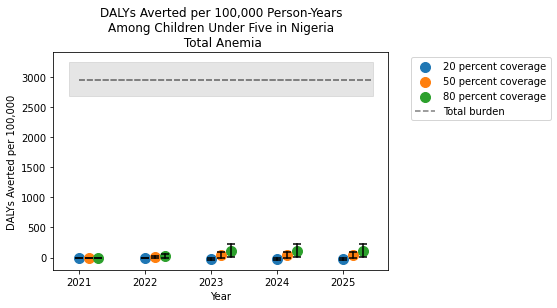

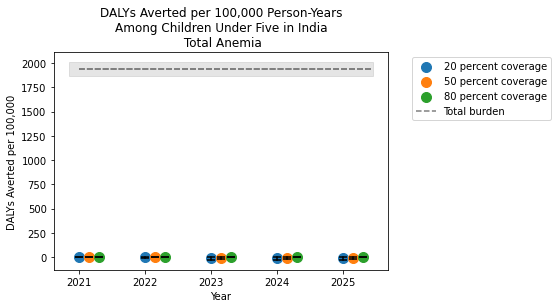

In [175]:
make_iron_plots(214, 'anemic_ylds', True)
make_iron_plots(163, 'anemic_ylds', True)

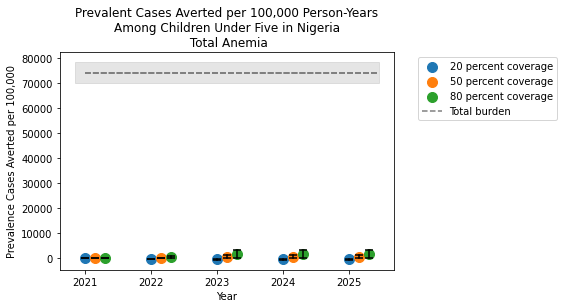

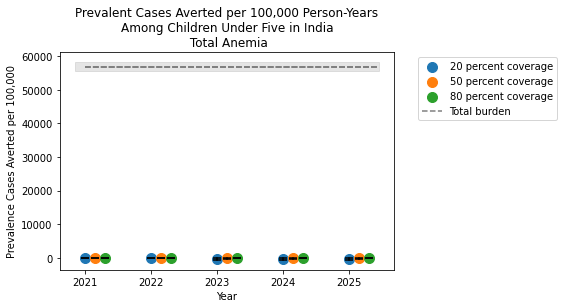

In [172]:
make_iron_plots(214, 'anemic', True)
make_iron_plots(163, 'anemic', True)

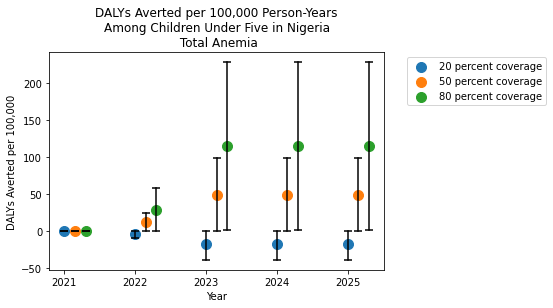

In [169]:
make_iron_plots(214, 'anemic_ylds', False)

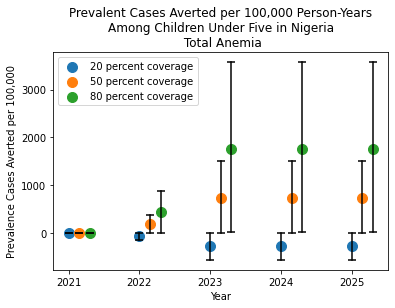

In [127]:
make_iron_plots(214, 'anemic')